In [1]:
import pywt, os, sys, glob
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import template_lc

In [2]:
import george
from george import kernels

In [74]:
listobs = glob.glob('./LC/*dat')
print(len(listobs))
listobs[40:50]

136


['./LC/LSST_1990N_z=0.1_34.dat',
 './LC/LSST_1990N_z=0.1_12.dat',
 './LC/LSST_1990N_z=0.1_14.dat',
 './LC/LSST_1990N_z=0.1_17.dat',
 './LC/LSST_1990N_z=0.8_23.dat',
 './LC/LSST_1990N_z=0.1_18.dat',
 './LC/LSST_1990N_z=0.8_24.dat',
 './LC/LSST_2010jl_z=0.1_12.dat',
 './LC/LSST_2010jl_z=0.1_14.dat',
 './LC/LSST_2010jl_z=0.1_17.dat']

In [102]:
obs={l:{}for l in listobs}
for lobs in obs.keys():
    f= open(lobs,'r')
    r= f.read()
    l =r.split('\n')
    idx_z = np.where(np.array(l)=='REDSHIFT_FINAL:  0.1 +- 0.700 (CMB)')
    z=float(np.array(r.split('\n'))[6].split()[1])
    idx_in = np.where(np.array(l)=='VARLIST:  MJD  FLT FIELD   FLUXCAL   FLUXCALERR   SNR    MAG     MAGERR ')
    idx_end= np.where(np.array(l)=='END: ')
    e_obs,m_obs,err_obs,f_obs=[],[],[],[]
    for i in np.arange(idx_in[0][0]+1,idx_end[0][0],1):
        e_obs.append(float(l[i].split()[1]))
        m_obs.append(float(l[i].split()[-2]))
        err_obs.append(float(l[i].split()[-1]))
        f_obs.append(l[i].split()[2])
    obs[lobs].update({z:{'epoch':np.array(e_obs),
                      'mag':np.array(m_obs),
                      'mag_err':np.array(err_obs),'filter':np.array(f_obs)}})
    

In [3]:
sn_group={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],100)}}

In [36]:
sn_group={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)},
              'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)},                        # 10
              'IIn':{'IIn':(['2010jl'],45),
                     'IIna':(['1998S'],45), 
                     'IIpec':(['1997cy','2005gj'],10)},
              'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}, 
              'SLSN' : {'SLSN':(['2008es'],100)}}

In [4]:
kernel = 1.0 * kernels.Matern32Kernel(1.0, ndim=2)
gp = george.GP(kernel)

In [37]:
temp = template_lc.template_lc(sn_group=sn_group ,
                               z_min=0.1,z_max= 0.2,z_step=0.1)
obs_template = temp.run()

I'm reading the templates
1990N g B 0.1
1990N r R 0.1
1990N i R 0.1
1992A g B 0.1
1992A r R 0.1
1992A i R 0.1
1994D g B 0.1
1994D r R 0.1
1994D i R 0.1
2002bo g B 0.1
2002bo r R 0.1
2002bo i R 0.1
1991T g B 0.1
1991T r R 0.1
1991T i R 0.1
1999ee g B 0.1
1999ee r R 0.1
1999ee i R 0.1
1991bg g B 0.1
1991bg r R 0.1
1991bg i R 0.1
2000cx g B 0.1
2000cx r R 0.1
2000cx i R 0.1
2002cx g B 0.1
2002cx r R 0.1
2002cx i R 0.1
1999em g B 0.1
1999em r R 0.1
1999em i R 0.1
2004et g B 0.1
2004et r R 0.1
2004et i R 0.1
2009bw g B 0.1
2009bw r R 0.1
2009bw i R 0.1
1999br g B 0.1
1999br r R 0.1
1999br i R 0.1
1999gi g B 0.1
1999gi r R 0.1
1999gi i R 0.1
2005cs g B 0.1
2005cs r R 0.1
2005cs i R 0.1
1992H g B 0.1
1992H r R 0.1
1992H i R 0.1
1993J g B 0.1
1993J r R 0.1
1993J i R 0.1
2008ax g B 0.1
2008ax r R 0.1
2008ax i R 0.1
1987A g B 0.1
1987A r R 0.1
1987A i R 0.1
2010jl g B 0.1
2010jl r R 0.1
2010jl i R 0.1
1998S g B 0.1
1998S r R 0.1
1998S i R 0.1
1997cy g B 0.1
1997cy r R 0.1
1997cy i R 0.1
2005gj g

In [20]:
np.shape(obs_template['magobs'][t][0.1][f])

(204,)

### GP Regression

In [105]:
t_pred= {t:None for t in obs_template['magobs'].keys()}
for t in obs_template['magobs'].keys():
    
    mag = np.concatenate([obs_template['magobs'][t][0.1][f]for f in ['g','r','i']])
    epoch = np.concatenate([obs_template['phobs'][t][0.1][f]for f in ['g','r','i']])
    mag_err=0.5 * np.ones_like(mag)
    #flux = {f:10**(-0.4*mag[f])*1e11 for f in mag.keys()}
    #flux_err={f:flux[f]*mag_err[f]*(0.4/np.log10(2.73)) for f in mag.keys()}
    spectra= []
    for f in obs_template['fobs'][t][0.1][0]:
        if f=='r':
            spectra.append(np.random.uniform(320.5,393.5,1))
        if f =='i':
            spectra.append(np.random.uniform(691.0,818.0,1))
        if f=='g':
            spectra.append(np.random.uniform(401.5,551.9,1))
    spectra=np.concatenate(spectra)

    #for f in ['g','r','i']:
    d2d = np.matrix([epoch,spectra])
    gp.compute(d2d.T,mag_err)
    def neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(mag)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(mag)
    result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
    print(result)
    pred, pred_var = {t:None for t in ['g','r','i']},{t:None for t in ['g','r','i']}
    gp.set_parameter_vector(result.x)
    print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(mag)))
    e_pred = np.linspace(-20,100,100)
    s_pred = np.linspace(350,830,100)
    
    pred, pred_var = gp.predict(mag, np.transpose([e_pred, s_pred]), return_var=True)
    t_pred[t] = (pred, pred_var)

      fun: 902.6963944404217
 hess_inv: array([[2.95124364, 1.98127893],
       [1.98127893, 1.33488808]])
      jac: array([-1.57839440e-06,  2.47956882e-06])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 13
     njev: 15
   status: 0
  success: True
        x: array([11.63587458, 13.90523592])

Final ln-likelihood: -902.70
      fun: 788.5461912616057
 hess_inv: array([[0.00490869, 0.0055371 ],
       [0.0055371 , 0.02525499]])
      jac: array([-0.00024899,  0.00038035])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 162
      nit: 8
     njev: 141
   status: 2
  success: False
        x: array([12.78443904, 14.90206578])

Final ln-likelihood: -788.55
      fun: 630.8368921801136
 hess_inv: array([[2.96999522, 1.99840944],
       [1.99840944, 1.34920894]])
      jac: array([-0.00019341,  0.00030637])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 99
      nit: 7
     njev: 88


In [107]:
t_eval= {t:{z:None for z in obs[t].keys()} for t in obs.keys()}
for t in obs.keys():
    for z in obs[t].keys():
        if len(obs[t][z]['mag'])>5:
            mag_obs = obs[t][z]['mag']
            epoch_obs = obs[t][z]['epoch']- min(obs[t][z]['epoch'])
            mag_err_obs= obs[t][z]['mag_err']
            #spectra=[]
            #for f in obs[t][z]['filter']:
            #    if f=='r':
            #        spectra.append(np.random.uniform(320.5,393.5,1))
            #    if f =='i':
            #        spectra.append(np.random.uniform(691.0,818.0,1))
            #    if f=='g':
            #        spectra.append(np.random.uniform(401.5,551.9,1))
            #spectra=np.concatenate(spectra)

            #d2d = np.matrix([epoch,spectra])
            #gp.compute(d2d.T,mag_err)
            #def neg_ln_like(p):
            #    gp.set_parameter_vector(p)
            #    return -gp.log_likelihood(mag)

            #def grad_neg_ln_like(p):
            #    gp.set_parameter_vector(p)
            #    return -gp.grad_log_likelihood(mag)
            #result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
            #print(result)

            #gp.set_parameter_vector(result.x)
            #print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(mag)))
            e_pred = np.linspace(-20,100,100)
            s_pred = np.linspace(350,830,100)
            pred, pred_var = gp.predict(mag_obs, np.transpose([e_pred, s_pred]), return_var=True)
            t_eval[t][z] = (pred, pred_var)

ValueError: Dimension mismatch

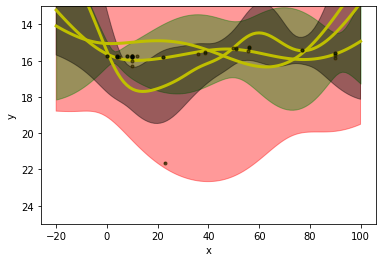

In [104]:
t =np.linspace(-20,100,100)

for f,c in zip(['g','r','i'],['red','green','black']):
    if f =='r':
        s = np.linspace(320.5,393,100)
    if f == 'g':
        s = np.linspace(401.5,551.9,100)
    if f == 'i':
        s = np.linspace(691.0,818.0,100)
    mpred,vperd=gp.predict(mag, np.transpose([np.linspace(-20,100,100),s ]), return_var=True)
    plt.errorbar(epoch, mag, yerr=mag_err, fmt=".", color=c, capsize=0,alpha=0.3)
    plt.fill_between(t, mpred - np.sqrt(vperd), mpred + np.sqrt(vperd),
                    color=c, alpha=0.4)
    plt.plot(t, mpred, 'y', lw=3, alpha=1)
    #pl.plot(x_pred, np.sin(x_pred), "--g")
    #plt.xlim(-21, 50)
    plt.ylim(13, 25)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()

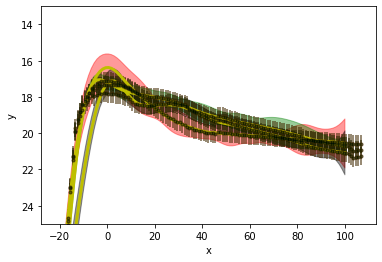

In [35]:
t =np.linspace(-20,100,100)

for f,c in zip(['g','r','i'],['red','green','black']):
    if f =='r':
        s = np.linspace(320.5,393,100)
    if f == 'g':
        s = np.linspace(401.5,551.9,100)
    if f == 'i':
        s = np.linspace(691.0,818.0,100)
    mpred,vperd=gp.predict(mag, np.transpose([np.linspace(-20,100,100),s ]), return_var=True)
    plt.errorbar(epoch, mag, yerr=mag_err, fmt=".", color=c, capsize=0,alpha=0.3)
    plt.fill_between(t, mpred - np.sqrt(vperd), mpred + np.sqrt(vperd),
                    color=c, alpha=0.4)
    plt.plot(t, mpred, 'y', lw=3, alpha=1)
    #pl.plot(x_pred, np.sin(x_pred), "--g")
    #plt.xlim(-21, 50)
    plt.ylim(13, 25)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()

### Wavelet decomposition

In [48]:
data_pywt = {t:t_pred[t][0]  for t in t_pred.keys()}

In [407]:
data_eval = {t:np.concatenate([t_eval[t][z][0][f] for f in t_eval[t][z][0].keys() for z in t_eval[t].keys() ])  for t in t_eval.keys()}

In [49]:
coeff = {t:pywt.wavedec(data_pywt[t],'db1',level=1) for t in t_pred.keys()}
#coeff_eval = {t: pywt.wavedec(data_eval[t],'db1',level=2) for t in t_eval.keys()}

In [50]:
coeff

{'1990N': [array([33.46971001, 31.63965886, 31.19801911, 30.15473652, 25.4732386 ,
         24.44574289, 24.36537588, 24.14833938, 23.97672962, 24.23724311,
         23.92946204, 24.76746989, 25.4363435 , 25.6689632 , 25.95597155,
         26.29620982, 26.49347124, 26.77267922, 27.12772459, 27.44718783,
         27.5891674 , 27.46410698, 26.85821907, 25.80259969, 24.509966  ,
         23.24647626, 22.30287877, 21.9508862 , 22.37275915, 23.56052784,
         25.22338772, 26.8211934 , 27.83946898, 28.18558866, 28.27830689,
         28.384903  , 28.49275128, 28.59661376, 28.6917925 , 28.79025626,
         28.89379683, 29.00706428, 29.05582975, 28.79910246, 28.04409268,
         26.75640061, 25.00553054, 22.89863402, 20.54406803, 18.03560709]),
  array([ 0.53006461,  0.35665387, -0.13521993,  0.87458496,  0.83392028,
          0.06240643,  0.00456861,  0.09448377, -0.03099915, -0.03254122,
         -0.00371033, -0.26891135, -0.07621124, -0.03240228, -0.11362708,
         -0.04904663, -0.05

### PCA of Wavelet

In [51]:
pca_matrix = np.matrix([pywt.waverec(coeff[t],'db1') for t in coeff.keys()])
pca_mean = np.mean(pca_matrix,axis=1)
matrix = pca_matrix -pca_mean

In [444]:
pca_matrix_eval = np.matrix([pywt.waverec(coeff_eval[t],'db1') for t in coeff.keys()])
pca_mean_eval = np.mean(pca_matrix,axis=1)
matrix_eval = pca_matrix_eval -pca_mean_eval

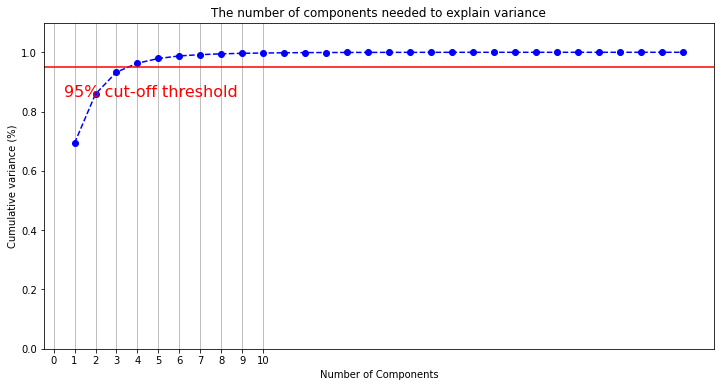

In [52]:
from sklearn.decomposition import PCA
pca = PCA().fit(matrix)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 31, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [53]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(matrix)

In [54]:
component = pca.fit(matrix)

In [416]:
component_eval = pca.fit(matrix_eval)

In [55]:
np.shape(component.components_)

(4, 100)

In [317]:
import lightgbm as lgb

In [418]:
lgb_train = lgb.Dataset(component.components_)
lgb_eval = lgb.Dataset(component_eval.components_, reference=lgb_train)

In [375]:
component.components_.T

array([[-3.43504684e-02,  3.15571949e-02,  1.32940854e-01,
         1.10758264e-01,  2.07369787e-01],
       [-3.02840021e-02,  3.91443870e-02,  1.40847922e-01,
         1.08195608e-01,  1.97070698e-01],
       [-1.69434922e-02,  5.57108630e-02,  1.28285000e-01,
         8.34032342e-02,  9.13625162e-02],
       ...,
       [-2.08286258e-02, -5.23183399e-03, -5.30270455e-03,
         3.65207873e-04, -1.28330321e-03],
       [-2.09670507e-02, -5.18816304e-03, -5.23088351e-03,
         2.01840027e-04, -1.74556523e-03],
       [-2.10380061e-02, -5.14258450e-03, -5.40466478e-03,
         6.14664500e-05, -2.00813321e-03]])

In [419]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

eval_results={}
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=[lgb_eval,lgb_train],
                categorical_feature=[21],
                evals_result=eval_results,
                verbose_eval=10)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [21]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that m

In [420]:
def render_metric(metric_name):
    ax = lgb.plot_metric(eval_results, metric=metric_name, figsize=(10, 5))
    plt.show()

In [421]:
render_metric(params['metric'][0])

TypeError: 'set' object does not support indexing